In [25]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

In [26]:

df = pd.read_csv('../datasets/merge_3months.csv')
drop_sent = ['date','user_followers', 'user_favourites','user_verified','sentimental_value']
xtreme = ['date','Close','High','Low','Volume','VWAP','Target']
openMod = ['date','Open']
volume = ['date','Volume','VWAP','Target']
highLow = ['date','High','Low']
df = df.drop(xtreme+drop_sent, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33247 entries, 0 to 33246
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         33247 non-null  float64
 1   is_positive  33247 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 519.6 KB


In [27]:
num_col = 1
# split into train&val , test set with 0.2
train_set, test_set = train_test_split(df, test_size=0.3)
# X train, first 5 column
X_train = train_set.iloc[:,0:num_col].values
# Y value the predicted  the last column
Y_train = train_set.iloc[:,num_col].values
# defining test dataset
X_test = test_set.iloc[:,0:num_col].values
Y_test = test_set.iloc[:,num_col].values


In [28]:
model = XGBClassifier(
    learning_rate=0.1,
    max_depth= 5000,
    n_estimators = 3000,
    subsample= 1,
    colsample_bytree=0.5,
    eval_metric ='auc',
    verbosity=1
)

eval_set = [(X_test, Y_test)]


model.fit(
    X_train,
    Y_train,
    early_stopping_rounds=10,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-auc:0.50433
[1]	validation_0-auc:0.50323


C:\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-auc:0.50314
[3]	validation_0-auc:0.50244
[4]	validation_0-auc:0.50289
[5]	validation_0-auc:0.50253
[6]	validation_0-auc:0.50227
[7]	validation_0-auc:0.50190
[8]	validation_0-auc:0.50217
[9]	validation_0-auc:0.50237
[10]	validation_0-auc:0.50259


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5000,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [29]:
y_true = np.array(Y_test.tolist())
y_pred = model.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred > 0.5, 1, 0)   # Change values into 1s or 0s

y_pred

array([1, 0, 0, ..., 0, 1, 0])

Text(33.0, 0.5, 'Truth')

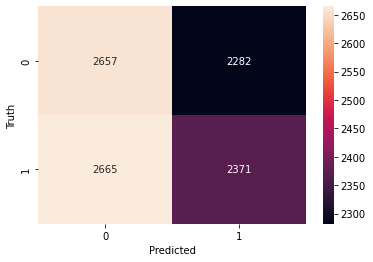

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52      4939
           1       0.51      0.47      0.49      5036

    accuracy                           0.50      9975
   macro avg       0.50      0.50      0.50      9975
weighted avg       0.50      0.50      0.50      9975



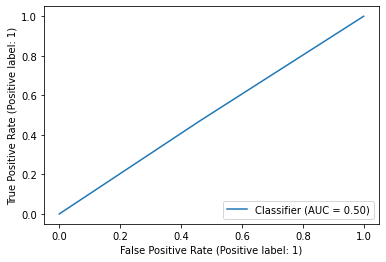

In [32]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_pred)

In [33]:
model.save_model('../saved_model/3_month/model_xtreme_nosent_3month_full.txt')

In [34]:
# learning_rate_list = [0.02, 0.05, 0.1]
# max_depth_list = [2000, 3000, 5000]
# n_estimators_list = [1000, 2000, 3000]

# params_dict = {"learning_rate": learning_rate_list,
#                "max_depth": max_depth_list,
#                "n_estimators": n_estimators_list}

# num_combinations = 1
# for v in params_dict.values(): num_combinations *= len(v) 

# print(num_combinations)
# params_dict

In [35]:
# def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

# model_xgboost_hp = GridSearchCV(estimator=XGBClassifier(subsample=0.5,
#                                                                 colsample_bytree=0.25,
#                                                                 eval_metric='auc',
#                                                                 use_label_encoder=False),
#                                 param_grid=params_dict,
#                                 cv=2,
#                                 scoring=my_roc_auc_score,
#                                 return_train_score=True,
#                                 verbose=4)
# 14
# model_xgboost_hp.fit(X_train, Y_train)

In [36]:
# df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
# df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
#                                'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
# df_cv_results.sort_values(by='rank_test_score', inplace=True)
# df_cv_results
